In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations

import choix

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [2]:
def AR1_generate(n, rho):
    """ Generate a single path of an AR(1) process of length n with parameter rho. """
    vals = np.zeros(n+1)
    vals[0] = np.random.normal()

    for i in range(1, n+1):
        vals[i] = rho * vals[i-1] + np.sqrt(1-rho**2)*np.random.normal()

    return vals[1:]

def AR1_many_paths(n_paths, n_steps, rho):
    """ Generate n_paths of an AR(1) process of length n_steps with parameter rho. """

    paths = np.zeros((n_paths, n_steps))

    for i in range(n_paths):
        paths[i, :] = AR1_generate(n_steps, rho)
        
    return paths


In [3]:
def noisy_utilities(n_items, n_steps, scale, rho):
    """ Generate a sequence of noisy utilities for n_items with given scale, length n_steps, and AR(1) noise parameter rho. """

    true_utilities = scale * np.arange(0, n_items)
    noisy_utilities = np.zeros((n_items, n_steps))

    for i in range(n_items):
        noisy_utilities[i, :] = AR1_generate(n_steps, rho) + true_utilities[i]

    return noisy_utilities

def perform_comparisons(comparisons, u):
    """ Perform comparisons based on noisy utilities u. 
    Args:
        comparisons: list of tuples (i, j) indicating items to compare
        u: 2D array of shape (n_items, n_steps) with noisy utilities
    Returns:
        a list of tuples indicating the winner and loser for each comparison.
    """
    res = []
    for k, comp in enumerate(comparisons):
        i, j = comp

        if u[i, k] < u[j, k]:
            res.append((j, i))
        else:
            res.append((i, j))
    return res

def static_noisy_comparator(u):
    """ Returns a comparator function based on noisy utilities u. """
    return lambda x, y: 1 if u[x] > u[y] else -1

def dynamic_noisy_comparator(u):
    """ Returns a comparator function based on noisy utilities u that changes over time. """
    step = 0
    def comparator(x, y):
        nonlocal step
        result = 1 if u[x, step] > u[y, step] else -1
        step += 1
        return result
    return comparator

In [4]:
def noisy_quicksort(arr, comparator=lambda x, y: x - y):
    """ Simple quicksort implementation for sorting an array using a noisy comparator function. """
    if len(arr) <= 1:
        return arr
    pivot = arr[len(arr) // 2]
    left = []
    right = []
    for x in arr:
        if x == pivot:
            continue
        cmp = comparator(x, pivot)
        if cmp < 0:
            left.append(x)
        else:
            right.append(x)
    return noisy_quicksort(left, comparator) + [pivot] + noisy_quicksort(right, comparator)

def noisy_mergesort_1(arr, comparator=lambda x, y: x - y):
    """ Simple mergesort implementaton"""
    if len(arr) <= 1:
        return arr
    mid = len(arr) // 2
    left = noisy_mergesort_1(arr[:mid], comparator)
    right = noisy_mergesort_1(arr[mid:], comparator)

    merged = []
    i = j = 0
    while i < len(left) and j < len(right):
        cmp = comparator(left[i], right[j])
        if cmp < 0:
            merged.append(left[i])
            i += 1
        else:
            merged.append(right[j])
            j += 1
    merged.extend(left[i:])
    merged.extend(right[j:])
    return merged
    
def noisy_mergesort_2(arr, comparator=lambda x, y: x - y):
    """ Another mergesort implementation"""
    width = 1
    n = len(arr)
    arr1 = [[x] for x in arr]
    while width < n:
        n1 = len(arr1)
        n2 = (n1 + 1) // 2
        arr2 = [[] for _ in range(n2)]
        count = 0
        while count<n: # Add one element to each arr in arr2 at a time until all elements are added, this ensures an item is not compared too many times in a row
            print("count:", count)
            for i2 in range(n2):
                i1 = 2*i2
                j1 = i1 + 1
                left = arr1[i1] if i1 < n1 else []
                right = arr1[j1] if j1 < n1 else []
                if len(left) == 0 and len(right) == 0:
                    continue
                if len(left)==0:
                    arr2[i2].extend(right)
                    continue
                if len(right) == 0:
                    arr2[i2].extend(left)
                    continue
                first_left = left[0]
                first_right = right[0]
                cmp = comparator(first_left, first_right)
                if cmp < 0:
                    arr2[i2].append(first_left)
                    arr1[i1] = left[1:]
                else:
                    arr2[i2].append(first_right)
                    arr1[j1] = right[1:]
                count += 1
        arr1 = arr2
        width *= 2
    return arr1[0]
            



In [5]:
def measure_displacement(ranking):
    """ Measure the displacement of a ranking from the true (increasing) order (of items 0, 1, ..., n-1)."""
    n = len(ranking)
    displacement = 0
    for i in range(n):
        displacement += abs(ranking[i] - i)
    return displacement

In [6]:
n = 50
rho = 0.8
scale = 1.0
n_steps = n*(n-1)//2
items = list(range(n))

iters = 100
algs = [noisy_quicksort, noisy_mergesort_1]## noisy_mergesort_2]
displacements = {alg.__name__: {'iid': [], 'temp': []} for alg in algs}

for alg in algs:
    print(f"Running algorithm: {alg.__name__}")
    for it in range(iters):
        # IID noise
        iid_u = noisy_utilities(n, n_steps, scale, 0)
        iid_comparator = dynamic_noisy_comparator(iid_u)
        ranking_static = alg(items, comparator=iid_comparator)
        displacement_static = measure_displacement(ranking_static)
        displacements[alg.__name__]['iid'].append(displacement_static)

        # Dynamic noise
        u = noisy_utilities(n, n_steps, scale, rho)
        dynamic_comparator = dynamic_noisy_comparator(u)
        ranking_dynamic = alg(items, comparator=dynamic_comparator)
        displacement_dynamic = measure_displacement(ranking_dynamic)
        displacements[alg.__name__]['temp'].append(displacement_dynamic)

Running algorithm: noisy_quicksort
Running algorithm: noisy_mergesort_1


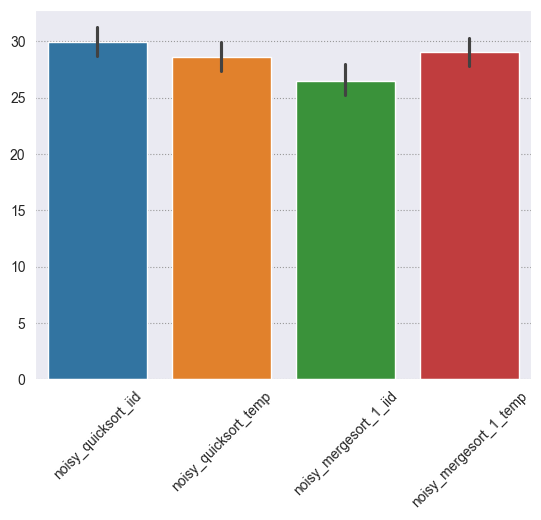

In [7]:
data = {f"{a}_{v}": val for a, sub in displacements.items() for v, val in sub.items()}
sns.barplot(data=data)
# tilt x labels
plt.xticks(rotation=45)
plt.show()